### Test the pretrained model

Get the game screen as the input, and use the virtual joystick to steer the wheel.

In [1]:
import sys
sys.path.append('../')

In [2]:
from europilot.screen import stream_local_game_screen
from europilot.screen import Box
from europilot.joystick import LinuxVirtualJoystick

### Load pretrained model, and check performance for each forward pass.
The performance needs to be checked, because it determines the fps of our program.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import os
import numpy as np
from PIL import Image
from time import time

import keras
from keras.models import load_model
from keras.preprocessing import image

parent_path = os.path.dirname(os.getcwd())
model_path = os.path.join(parent_path, 'model')

# multiply by constant to undo normalization
OUTPUT_NORMALIZATION = 655.35

Using TensorFlow backend.


In [4]:
# limit GPU memory usage
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
set_session(tf.Session(config=config))

load pretrained model

In [2]:
%ls $model_path

9d0c3c2b.h5                    v5-PilotNet_v3-001-2.05196.h5
log/                           v5-PilotNet_v3-002-0.86883.h5
old/                           v5-PilotNet_v3-003-0.82028.h5
v5-PilotNet_v2-000-0.82017.h5  v5-PilotNet_v3-004-0.78431.h5
v5-PilotNet_v2-001-0.80169.h5  v5-PilotNet_v3-008-0.76898.h5
v5-PilotNet_v2-004-0.79835.h5  v5-PilotNet_v3-009-0.76725.h5
v5-PilotNet_v2-005-0.79130.h5  v5-PilotNet_v3-010-0.69419.h5
v5-PilotNet_v2-006-0.68652.h5  v5-PilotNet_v3-013-0.69050.h5
v5-PilotNet_v2-008-0.67600.h5  v5-PilotNet_v3-040-0.69.h5
v5-PilotNet_v2-009-0.67221.h5


In [5]:
model = load_model(os.path.join(model_path, 'v5-PilotNet_v2-009-0.67221.h5'))

Get sample image, to find out the performance of our model

In [6]:
%ls ../sample/img/raw

9d0c3c2b_2017_07_27_14_55_08_16.jpg


In [7]:
sample_img = Image.open(os.path.join('../sample/img/raw', '9d0c3c2b_2017_07_27_14_55_08_16.jpg')).convert('RGB')

In [8]:
front_coord = (289,167, 851, 508)
sample_img_front = sample_img.crop(front_coord)

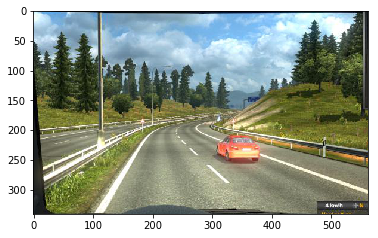

In [9]:
plt.imshow(sample_img_front)

In [10]:
sample_arr = image.img_to_array(sample_img_front)
sample_arr = np.reshape(sample_arr, (1,) + sample_arr.shape)

In [13]:
model.predict(sample_arr, batch_size = 1)
start = time()
for i in range(100):
    model.predict(sample_arr, batch_size = 1)
end = time()

fps = 100. / (end - start)
print("fps: %f" % fps)

fps: 48.851024


Be aware that the performance of the model can affect the performance of the overall program, since it may not react quickly enough to the changing environment.

### Setup virtual joystick.
Make sure to setup the virtual joystick inside ETS2 inside the controller settings.

Get the coordinates for the game screen. The values may be different per game setting.

In [14]:
x1, y1 = (68, 54)
x2, y2 = (x1 + 1024, y1 + 768)
box = Box(x1, y1, x2, y2)

In [15]:
joy = LinuxVirtualJoystick()

As seen below, a virtual device can now be detected.

In [16]:
!cat /proc/bus/input/devices

I: Bus=0019 Vendor=0000 Product=0003 Version=0000
N: Name="Sleep Button"
P: Phys=PNP0C0E/button/input0
S: Sysfs=/devices/LNXSYSTM:00/LNXSYBUS:00/PNP0C0E:00/input/input0
U: Uniq=
H: Handlers=kbd event0 
B: PROP=0
B: EV=3
B: KEY=4000 0 0

I: Bus=0019 Vendor=0000 Product=0001 Version=0000
N: Name="Power Button"
P: Phys=PNP0C0C/button/input0
S: Sysfs=/devices/LNXSYSTM:00/LNXSYBUS:00/PNP0C0C:00/input/input1
U: Uniq=
H: Handlers=kbd event1 
B: PROP=0
B: EV=3
B: KEY=10000000000000 0

I: Bus=0019 Vendor=0000 Product=0001 Version=0000
N: Name="Power Button"
P: Phys=LNXPWRBN/button/input0
S: Sysfs=/devices/LNXSYSTM:00/LNXPWRBN:00/input/input2
U: Uniq=
H: Handlers=kbd event2 
B: PROP=0
B: EV=3
B: KEY=10000000000000 0

I: Bus=0003 Vendor=046d Product=c29b Version=0111
N: Name="G27 Racing Wheel"
P: Phys=usb-0000:00:14.0-3/input0
S: Sysfs=/devices/pci0000:00/0000:00:14.0/usb1/1-3/1-3:1.0/0003:046D:C29B.0001/input/input6
U: Uniq=
H: Handlers=event3 js0 
B: PROP=0
B: EV=20001b
B: KEY=7f 0 0 0 0 0 0 ff

Set up game loop

In [17]:
# values computed from dataset sample.
def normalize(img):
    img[:,:,0] -= 89.5761
    img[:,:,0] /= 58.4214

    img[:,:,1] -= 97.5966
    img[:,:,1] /= 61.7917

    img[:,:,2] -= 88.3135
    img[:,:,2] /= 68.2043
    
    return img

def get_angle(predict):
    angle = predict[0][0]
    angle *= OUTPUT_NORMALIZATION
    
    return int(angle)

In [ ]:
streamer = stream_local_game_screen(box=box, default_fps=60)
while True:
    image_data = next(streamer)
    im = Image.fromarray(image_data)
    img_front = im.crop(front_coord)
    
    arr = image.img_to_array(img_front)
    arr = normalize(arr)
    arr = np.reshape(arr, (1,) + arr.shape)
    
    angle = get_angle(model.predict(arr, batch_size = 1))
    
    joy.emit(angle)